In [1]:
import pandas as pd
import geopandas as gpd
import os
import matplotlib.pyplot as plt
import osmnx as ox

### 1. Load isochrone polygon files as base

In [7]:
# import rail isochrones
rail_isochrone = gpd.read_file(os.path.join('data','cleaned','rail_isochrone_15m.gpkg'),crs='EPSG:27700')
rail_isochrone.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   id_code   400 non-null    int64   
 1   name      400 non-null    object  
 2   pt_type   400 non-null    object  
 3   geometry  400 non-null    geometry
dtypes: geometry(1), int64(1), object(2)
memory usage: 12.6+ KB


In [8]:
# import bus isochrones
bus_isochrone = gpd.read_file(os.path.join('data','cleaned','bus_isochrone_15m.gpkg'),crs='EPSG:27700')
bus_isochrone.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 16942 entries, 0 to 16941
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   id_code   16942 non-null  object  
 1   name      16942 non-null  object  
 2   pt_type   16942 non-null  object  
 3   geometry  16942 non-null  geometry
dtypes: geometry(1), object(3)
memory usage: 529.6+ KB


In [ ]:
# add prefix to column id_code of each df
rail_isochrone['id_code'] = 'R_' + rail_isochrone['id_code'].astype(str)
bus_isochrone['id_code'] = 'B_' + bus_isochrone['id_code'].astype(str)

In [ ]:
pt_isochrone = pd.concat([rail_isochrone,bus_isochrone])
pt_isochrone.reset_index(inplace=True, drop=True)
pt_isochrone.info()

### 2. Prep TARGET VARIABLE

In [ ]:
# SPATIAL
# centroid x and y
pt_isochrone['x'] = pt_isochrone.geometry.centroid.x
pt_isochrone['y'] = pt_isochrone.geometry.centroid.y

In [13]:
# Load processed BUSTO and NUMBAT data
flow_bus = gpd.read_file(os.path.join('data','cleaned','flow_bus_byStop_.gpkg'))
flow_rail = gpd.read_file(os.path.join('data','cleaned','flow_rail.gpkg'))

In [14]:
flow_rail.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   nlc          400 non-null    int64   
 1   stationname  400 non-null    object  
 2   Total        400 non-null    int64   
 3   Early        400 non-null    int64   
 4   AM Peak      400 non-null    int64   
 5   Midday       400 non-null    int64   
 6   PM Peak      400 non-null    int64   
 7   Evening      400 non-null    int64   
 8   Late         400 non-null    int64   
 9   geometry     400 non-null    geometry
dtypes: geometry(1), int64(8), object(1)
memory usage: 31.4+ KB


In [15]:
timebands = ['Total', 'Early', 'AM Peak', 'Midday', 'PM Peak', 'Evening', 'Late']

In [ ]:
# sum columns 2-8 of flow_rail that intersects with each isochrone
for i, row in pt_isochrone.iterrows():
    intersect = flow_rail[flow_rail.geometry.intersects(row.geometry)] # find intersected polygons
    for col in flow_rail[timebands].columns:
        value = intersect[col].sum()
        pt_isochrone.at[i, col] = round(value)
    # print progress
    if i%100==0:
        print(f'{i} of {len(pt_isochrone)} done')

# rename new columns adding a suffix _rail
for col in timebands:
    pt_isochrone.rename(columns={col: col+'_rail'}, inplace=True)

In [ ]:
# sum total_exits of flow_bus that intersects with each isochrone
for i, row in pt_isochrone.iterrows():
    intersect = flow_bus[flow_bus.geometry.intersects(row.geometry)] # find intersected polygons
    for col in flow_bus[timebands].columns:
        value = intersect[col].sum()
        pt_isochrone.at[i, col] = round(value)
    # print progress
    if i%100==0:
        print(f'{i} of {len(pt_isochrone)} done')

# rename new columns adding a suffix _bus
for col in timebands:
    pt_isochrone.rename(columns={col: col+'_bus'}, inplace=True)

In [ ]:
# Create a new column with the total number of exits for each timeband
for col in timebands:
    pt_isochrone[col+'_railbus'] = pt_isochrone[col+'_rail'] + pt_isochrone[col+'_bus']

In [16]:
# # # merge with pt_isochrone pt_type bus
# bus_isochrone_merge = bus_isochrone[['id_code','name','pt_type','geometry']].merge(flow_bus[['STOPCODE',
#                                             'Early',
#                                             # 'AM Peak',
#                                             # 'Midday',
#                                             # 'PM Peak',
#                                             # 'Evening',
#                                             # 'Late',
#                                             'Total']],left_on='id_code',right_on='STOPCODE',how='left').drop('STOPCODE',axis=1)

# # Sample dataset does not have other timebands for now -> insert dummy columns
# bus_isochrone_merge['AM Peak'] = 0
# bus_isochrone_merge['Midday'] = 0
# bus_isochrone_merge['PM Peak'] = 0
# bus_isochrone_merge['Evening'] = 0
# bus_isochrone_merge['Late'] = 0

# bus_isochrone_merge.fillna(0,inplace=True)
# bus_isochrone_merge.tail()

In [17]:
# # merge with pt_isochrone pt_type bus
# rail_isochrone_merge = rail_isochrone[['id_code','name','pt_type','geometry']].merge(flow_rail[['nlc',
#                                             'Early',
#                                             'AM Peak',
#                                             'Midday',
#                                             'PM Peak',
#                                             'Evening',
#                                             'Late',
#                                             'Total']],left_on='id_code',right_on='nlc',how='left').drop('nlc',axis=1)

# rail_isochrone_merge.tail()

#### Plot 

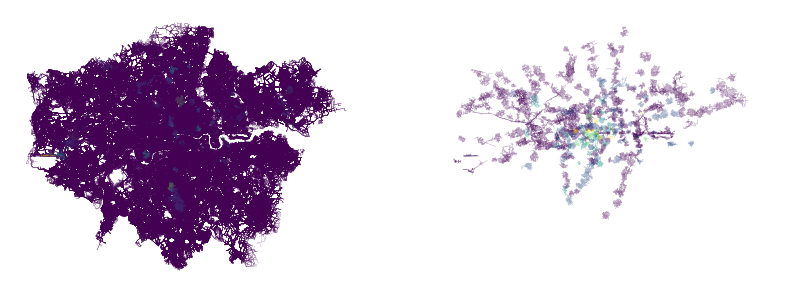

In [13]:
# plot them
fig, ax = plt.subplots(1,3,figsize=(10,20),sharex=True,sharey=True)
pt_isochrone.plot(ax=ax[0], column='Total_bus', alpha=0.5, cmap='viridis',scheme='NaturalBreaks',k=5)
pt_isochrone.plot(ax=ax[1], column='Total_rail', alpha=0.5, cmap='viridis',scheme='NaturalBreaks',k=5)
pt_isochrone.plot(ax=ax[2], column='Total_railbus', alpha=0.5, cmap='viridis',scheme='NaturalBreaks',k=5)
ax[0].axis('off')
ax[1].axis('off')
plt.show()

### 3. Prep FEATURES
#### 3.1 Aggregate intersecting Population and POI density

In [14]:
# import poi_pop_h3 file
poi_pop_h3 = gpd.read_file(os.path.join('data','cleaned','poi_pop_h3_r10.gpkg'))
poi_pop_h3.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 116586 entries, 0 to 116585
Data columns (total 18 columns):
 #   Column                     Non-Null Count   Dtype   
---  ------                     --------------   -----   
 0   h3                         116586 non-null  object  
 1   population                 116586 non-null  int64   
 2   poi_banking                116586 non-null  float64 
 3   poi_hotels                 116586 non-null  float64 
 4   poi_leisure_active         116586 non-null  float64 
 5   poi_leisure_entertainment  116586 non-null  float64 
 6   poi_leisure_outdoor        116586 non-null  float64 
 7   poi_medical                116586 non-null  float64 
 8   poi_nature                 116586 non-null  float64 
 9   poi_public_facilities      116586 non-null  float64 
 10  poi_religious              116586 non-null  float64 
 11  poi_restaurants            116586 non-null  float64 
 12  poi_shopping               116586 non-null  float64 
 13  poi_to

In [15]:
%%time
# takes 6hrs
df_ml = pt_isochrone.copy()

# for each isochrone, calculate the the values from poi_pop_h3 intersecting it 
for i, row in df_ml.iterrows():
    intersect = poi_pop_h3[poi_pop_h3.geometry.intersects(row.geometry)] # find intersected polygons
    #for all columns except geometry 
    for col in intersect.columns[1:-1]: 
        value = intersect[col].sum()
        df_ml.at[i, col] = round(value)
    
    # print progress
    if i%100==0:
        print(f'{i} of {len(df_ml)} done')

df_ml.head()

0 of 17342 done
100 of 17342 done
200 of 17342 done
300 of 17342 done
400 of 17342 done
500 of 17342 done
600 of 17342 done
700 of 17342 done
800 of 17342 done
900 of 17342 done
1000 of 17342 done
1100 of 17342 done
1200 of 17342 done
1300 of 17342 done
1400 of 17342 done
1500 of 17342 done
1600 of 17342 done
1700 of 17342 done
1800 of 17342 done
1900 of 17342 done
2000 of 17342 done
2100 of 17342 done
2200 of 17342 done
2300 of 17342 done
2400 of 17342 done
2500 of 17342 done
2600 of 17342 done
2700 of 17342 done
2800 of 17342 done
2900 of 17342 done
3000 of 17342 done
3100 of 17342 done
3200 of 17342 done
3300 of 17342 done
3400 of 17342 done
3500 of 17342 done
3600 of 17342 done
3700 of 17342 done
3800 of 17342 done
3900 of 17342 done
4000 of 17342 done
4100 of 17342 done
4200 of 17342 done
4300 of 17342 done
4400 of 17342 done
4500 of 17342 done
4600 of 17342 done
4700 of 17342 done
4800 of 17342 done
4900 of 17342 done
5000 of 17342 done
5100 of 17342 done
5200 of 17342 done
5300 

id_code pt_type                                           geometry  Early  \
0   R_750    rail  POLYGON ((538894.554 183025.869, 538893.934 18...     60   
1  R_5131    rail  POLYGON ((546817.720 178994.762, 546815.775 17...    151   
2  R_1404    rail  POLYGON ((520076.256 180087.693, 520076.059 18...      7   
3  R_3000    rail  POLYGON ((520167.664 180775.840, 520165.727 18...     92   
4   R_500    rail  POLYGON ((518842.951 178561.693, 518840.651 17...    182   

   AM Peak  Midday  PM Peak  Evening  Late  Total  ...  poi_medical  \
0      168     515      347      260   161   1511  ...          5.0   
1     1422    5519     4046     3119  2001  16258  ...          1.0   
2      164     730      593      327   176   1997  ...         12.0   
3       96     349      350      278   251   1416  ...          6.0   
4      741    2528     1666     1326  1129   7572  ...         10.0   

   poi_nature  poi_public_facilities  poi_religious  poi_restaurants  \
0        14.0                   15.0            4.0              6.0   
1         8.0                   15.0            3.0              2.0   
2         1.0                   51.0            8.0             68.0   
3         0.0                   25.0            3.0              9.0   
4         9.0                   79.0            8.0             63.0   

   poi_shopping  poi_tourism  transport_bus  transport_other  transport_rail  
0          12.0          9.0            5.0              0.0             1.0  
1           9.0          2.0           25.0              0.0             2.0  
2          87.0         16.0           49.0              0.0             2.0  
3          19.0          4.0           30.0              0.0             1.0  
4          70.0         14.0           40.0              0.0             4.0  

[5 rows x 26 columns]

In [16]:
# # save to csv
# df_ml.to_csv(os.path.join('data','cleaned','df_ml_31.csv'),index=False)

#### 3.2 Calculate POI diversity - Shannon entropy within each isochrone

In [ ]:
df_ml_div = df_ml.copy()

In [17]:
# Load borough shapefile for Islington borough using osmnx
boros = gpd.read_file(os.path.join('data','shapefile','statistical-gis-boundaries-london','ESRI','London_Borough_Excluding_MHW.shp'))
boros.to_crs(epsg=27700, inplace=True)

In [18]:
# calculate the entropy of all rows
from scipy.stats import entropy
def calc_poi_entropy(row):

    # get the values of the row only for columns whose name contain poi_
    c = row.filter(like='poi_').values.astype(int)
    # remove zeros
    c = c[c != 0]
    c = c / c.sum()
    # calculate the entropy
    ent = entropy(c)
    return ent

df_ml_div['diversity_poi'] = df_ml_div.apply(calc_poi_entropy, axis=1)

<Axes: title={'center': 'Top 10% POI diversity'}>

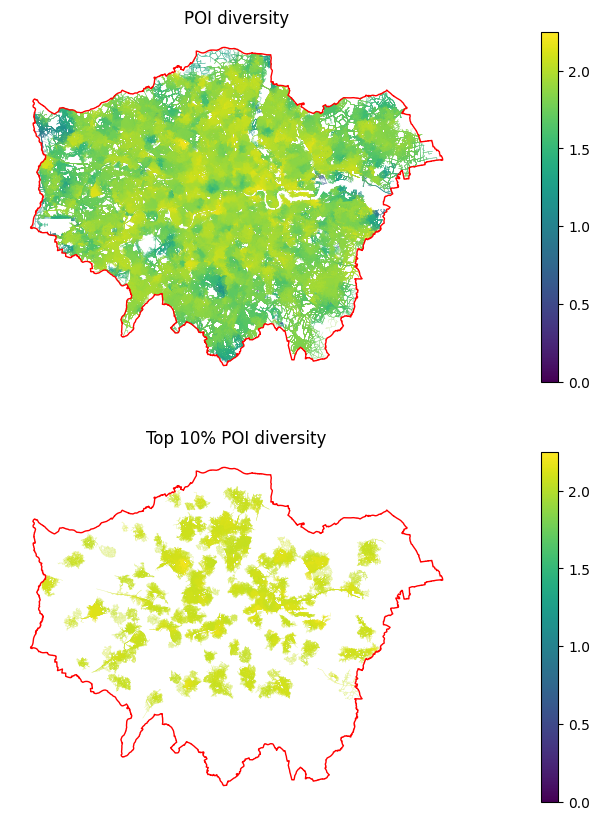

In [19]:
# plot it where entropy is greater than top quartile, same color scale
fig, ax = plt.subplots(2,1,figsize=(20,10))

vmin = df_ml_div.diversity_poi.min()
vmax = df_ml_div.diversity_poi.max()

df_ml_div.plot(column='diversity_poi', 
           ax=ax[0],
           legend=True, 
           alpha=0.5, 
           cmap='viridis',vmin=vmin,vmax=vmax
           ).set_title('POI diversity')
ax[0].axis('off')

df_ml_div[df_ml_div.diversity_poi > df_ml_div.diversity_poi.quantile(0.90)].plot(
            column='diversity_poi', 
            ax=ax[1],
            legend=True,
            alpha=0.5,
            cmap='viridis',vmin=vmin,vmax=vmax
            ).set_title('Top 10% POI diversity')
ax[1].axis('off')

# london boundary from osm
london = ox.geocode_to_gdf('Greater London, UK')
london.to_crs(epsg=27700, inplace=True)
london.boundary.plot(ax=ax[0], color='red', linewidth=1)
london.boundary.plot(ax=ax[1], color='red', linewidth=1)

#### 3.3 Calculate Transport mode diversity Bus/Rail/Other - Shannon entropy within each isochrone

In [20]:
# calculate the entropy of all rows
from scipy.stats import entropy
def calc_transport_entropy(row):
    # get the values of the row only for columns whose name contain poi_
    c = row.filter(like='transport_').values.astype(int)
    # remove zeros
    c = c[c != 0]
    c = c / c.sum()
    # calculate the entropy
    ent = entropy(c)
    return ent

df_ml_div['diversity_transp_mode'] = df_ml_div.apply(calc_transport_entropy, axis=1)

<Axes: title={'center': 'Top 10% Transport mode diversity'}>

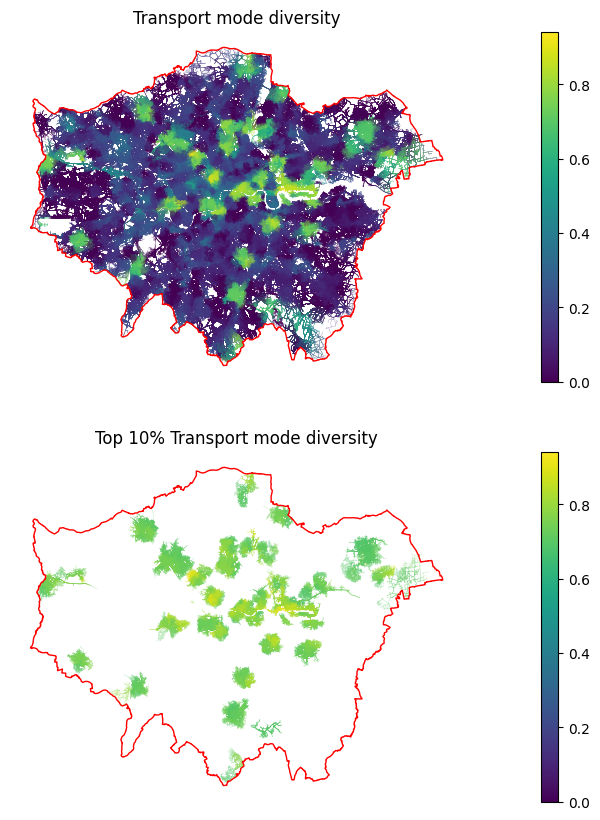

In [21]:
# plot it where entropy is greater than top quartile, same color scale
fig, ax = plt.subplots(2,1,figsize=(20,10))

vmin = df_ml_div.diversity_transp_mode.min()
vmax = df_ml_div.diversity_transp_mode.max()

df_ml_div.plot(column='diversity_transp_mode', 
           ax=ax[0],
           legend=True, 
           alpha=0.5, 
           cmap='viridis',vmin=vmin,vmax=vmax
           ).set_title('Transport mode diversity')
ax[0].axis('off')

df_ml_div[df_ml_div.diversity_transp_mode > df_ml_div.diversity_transp_mode.quantile(0.90)].plot(
            column='diversity_transp_mode', 
            ax=ax[1],
            legend=True,
            alpha=0.5,
            cmap='viridis',vmin=vmin,vmax=vmax
            ).set_title('Top 10% Transport mode diversity')
ax[1].axis('off')

# london boundary from osm
london = ox.geocode_to_gdf('Greater London, UK')
london.to_crs(epsg=27700, inplace=True)
london.boundary.plot(ax=ax[0], color='red', linewidth=1)
london.boundary.plot(ax=ax[1], color='red', linewidth=1)

#### 3.4 Transport operator mode

In [23]:
# import file transport mode diversity
ddf = pd.read_csv(os.path.join('data','cleaned','transp_opt_isochrones.csv'))
ddf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17342 entries, 0 to 17341
Data columns (total 3 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   id_code                    17342 non-null  object 
 1   transp_opt_entropy         17342 non-null  float64
 2   transp_opt_entropy_wo_hub  17342 non-null  float64
dtypes: float64(2), object(1)
memory usage: 406.6+ KB


In [24]:
# merge with df_ml
df_ml_div = df_ml_div.merge(ddf[['id_code','transp_opt_entropy']],on='id_code',how='left')
df_ml_div.rename(columns={'transp_opt_entropy':'diversity_transp_opt'},inplace=True)
df_ml_div.info() # should have 17342 rows

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 17342 entries, 0 to 17341
Data columns (total 29 columns):
 #   Column                     Non-Null Count  Dtype   
---  ------                     --------------  -----   
 0   id_code                    17342 non-null  object  
 1   pt_type                    17342 non-null  object  
 2   geometry                   17342 non-null  geometry
 3   Early                      17342 non-null  int32   
 4   AM Peak                    17342 non-null  int64   
 5   Midday                     17342 non-null  int64   
 6   PM Peak                    17342 non-null  int64   
 7   Evening                    17342 non-null  int64   
 8   Late                       17342 non-null  int64   
 9   Total                      17342 non-null  int32   
 10  population                 17342 non-null  float64 
 11  poi_banking                17342 non-null  float64 
 12  poi_hotels                 17342 non-null  float64 
 13  poi_leisure_active     

<Axes: title={'center': 'Top 10% Transport option diversity'}>

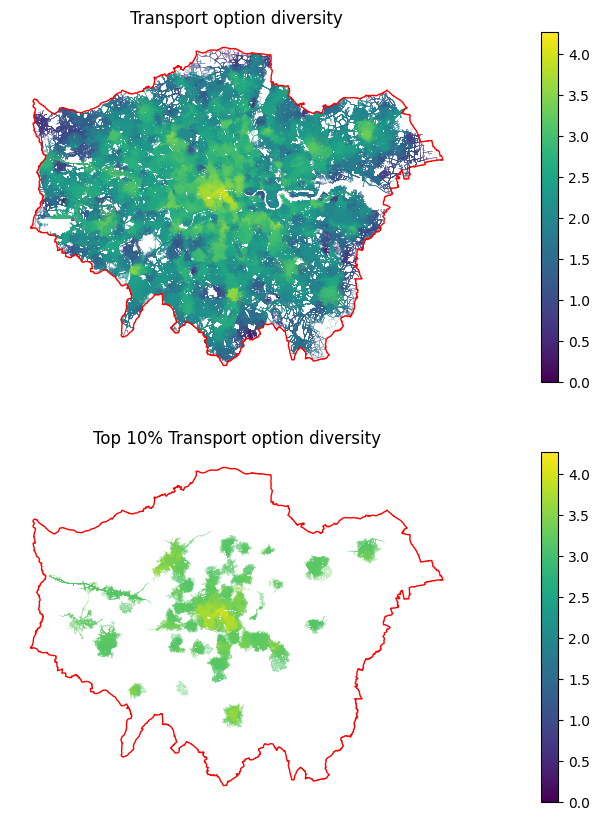

In [26]:
# plot it where entropy is greater than top quartile, same color scale
fig, ax = plt.subplots(2,1,figsize=(20,10))

vmin = df_ml_div.diversity_transp_opt.min()
vmax = df_ml_div.diversity_transp_opt.max()

df_ml_div.plot(column='diversity_transp_opt', 
           ax=ax[0],
           legend=True, 
           alpha=0.5, 
           cmap='viridis',vmin=vmin,vmax=vmax
           ).set_title('Transport option diversity')
ax[0].axis('off')

df_ml_div[df_ml_div.diversity_transp_opt > df_ml_div.diversity_transp_opt.quantile(0.90)].plot(
            column='diversity_transp_opt', 
            ax=ax[1],
            legend=True,
            alpha=0.5,
            cmap='viridis',vmin=vmin,vmax=vmax
            ).set_title('Top 10% Transport option diversity')
ax[1].axis('off')

# london boundary from osm
london = ox.geocode_to_gdf('Greater London, UK')
london.to_crs(epsg=27700, inplace=True)
london.boundary.plot(ax=ax[0], color='red', linewidth=1)
london.boundary.plot(ax=ax[1], color='red', linewidth=1)

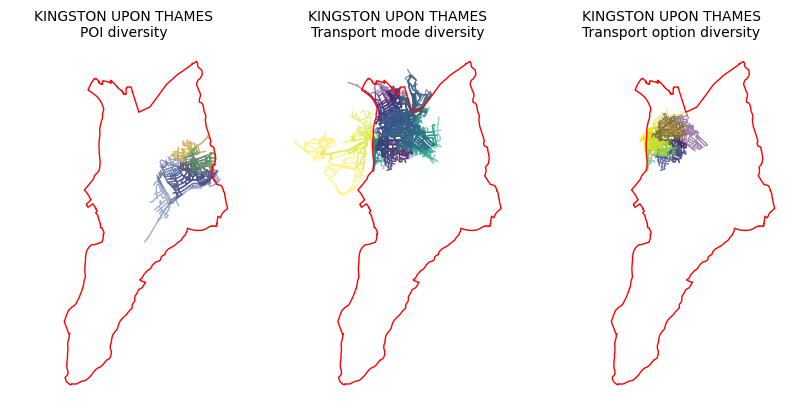

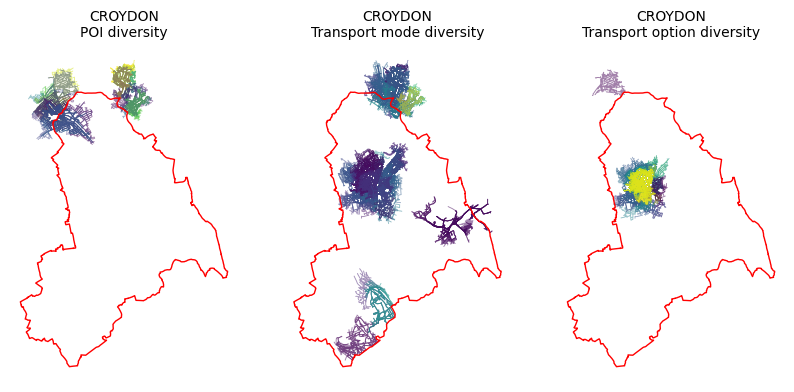

C:\Users\shaun\AppData\Local\Temp\ipykernel_28512\3288104172.py:37: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  df_plot[df_plot.intersects(boro_geom)].plot(


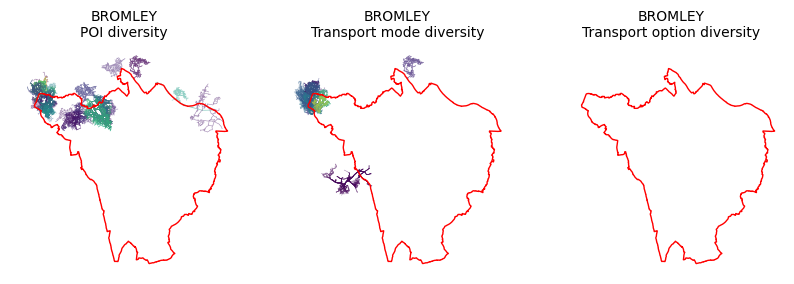

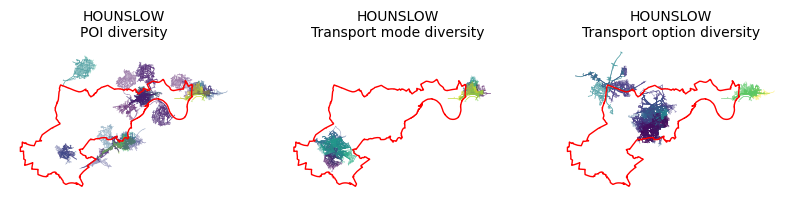

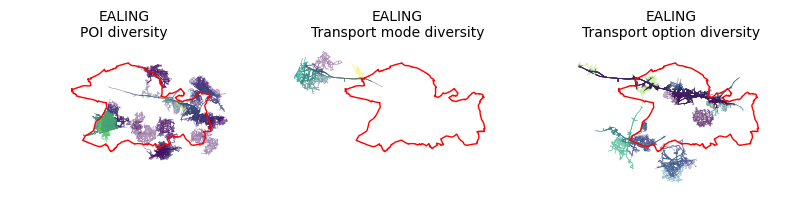

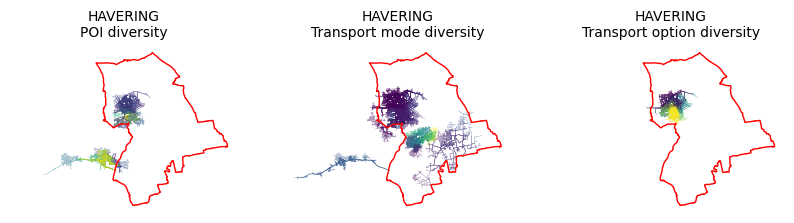

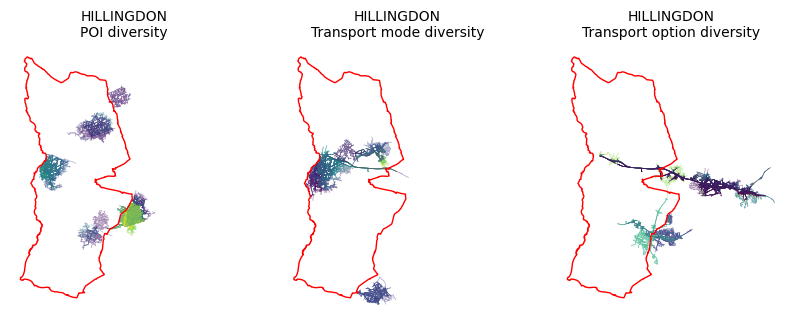

C:\Users\shaun\AppData\Local\Temp\ipykernel_28512\3288104172.py:37: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  df_plot[df_plot.intersects(boro_geom)].plot(


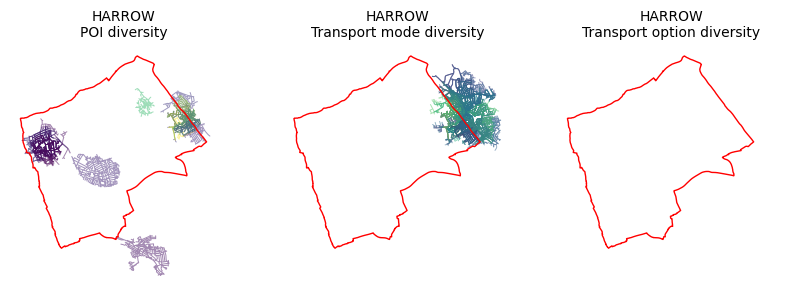

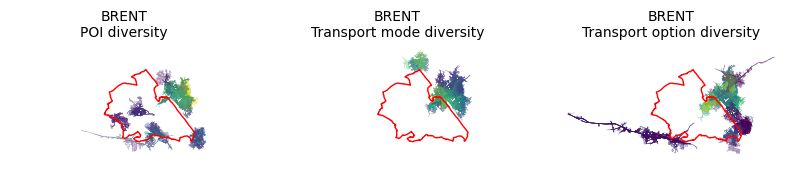

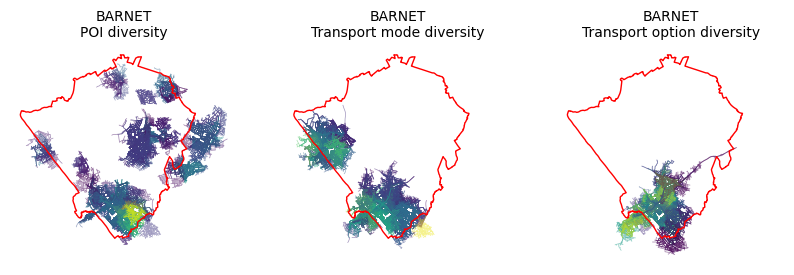

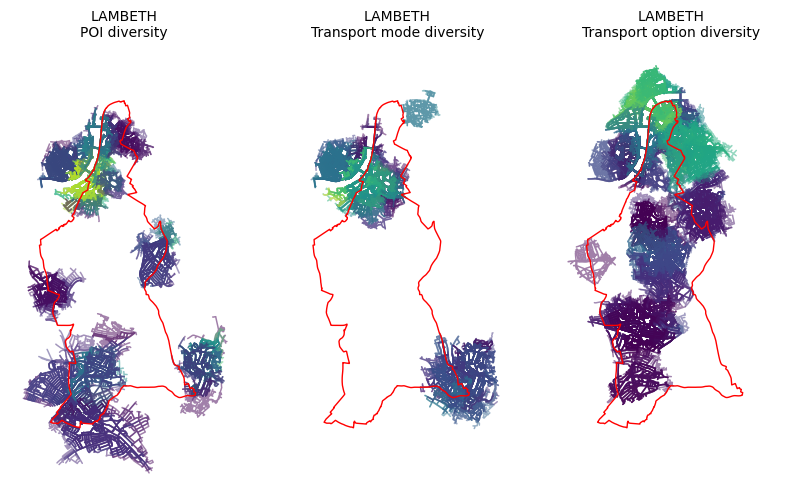

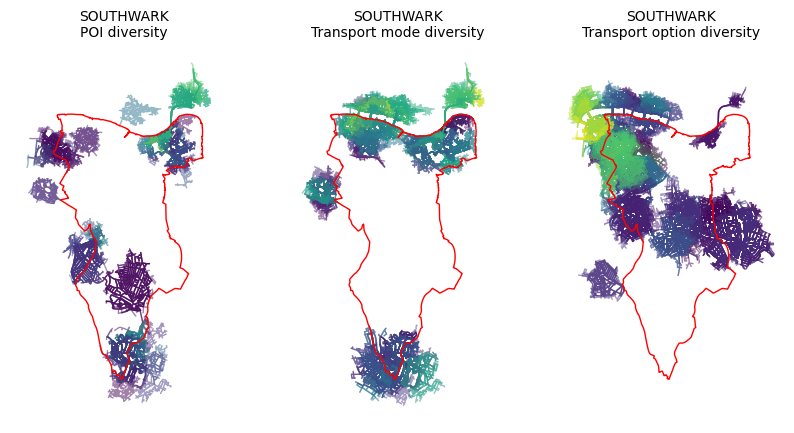

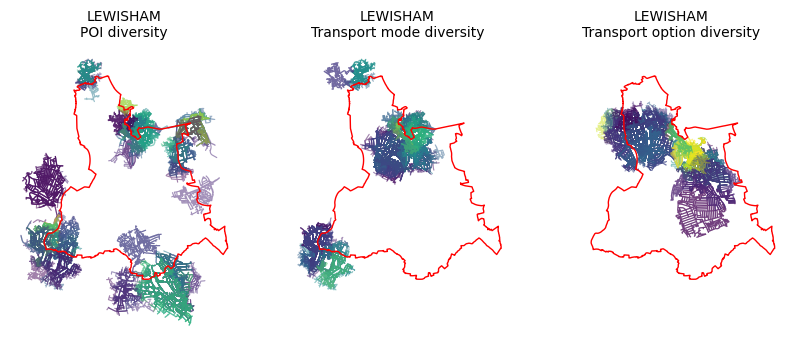

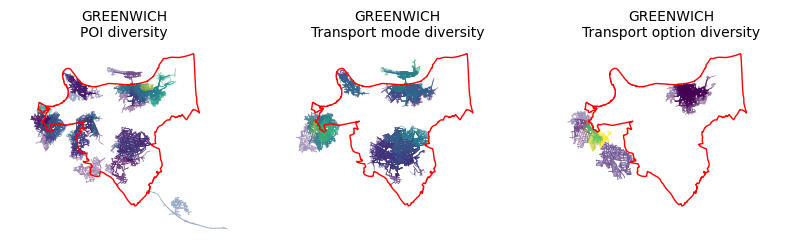

C:\Users\shaun\AppData\Local\Temp\ipykernel_28512\3288104172.py:37: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  df_plot[df_plot.intersects(boro_geom)].plot(


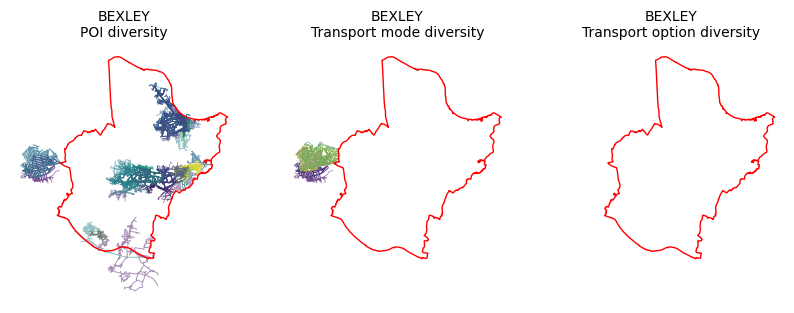

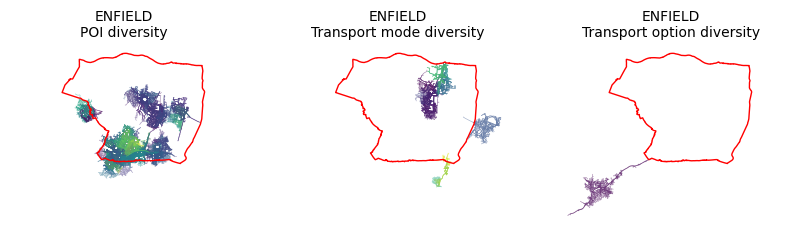

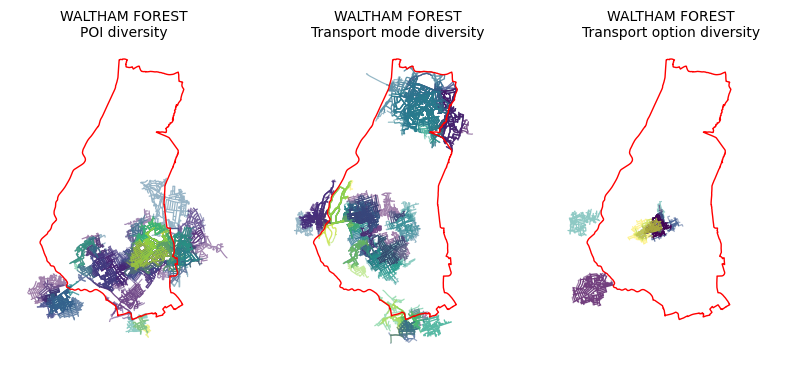

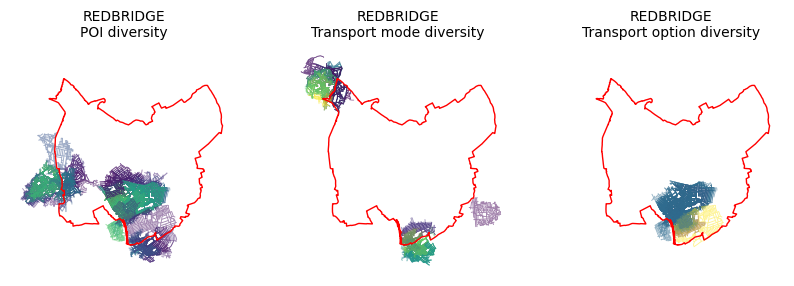

C:\Users\shaun\AppData\Local\Temp\ipykernel_28512\3288104172.py:12: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  df_plot[df_plot.intersects(boro_geom)].plot(


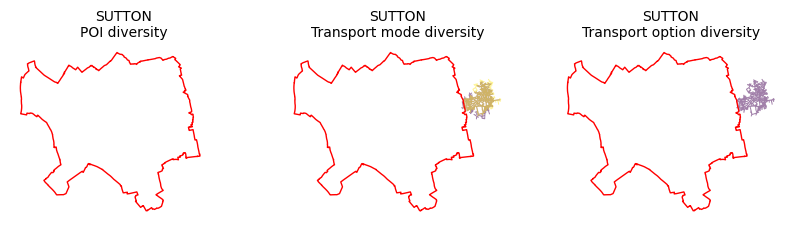

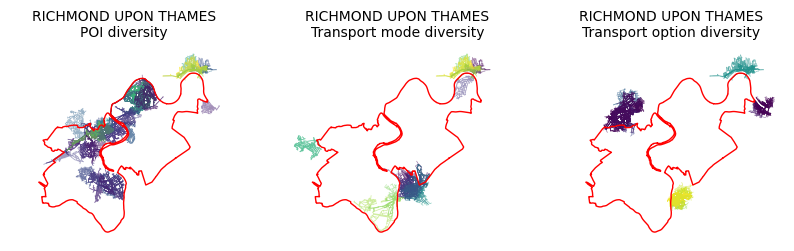

C:\Users\shaun\AppData\Local\Temp\ipykernel_28512\3288104172.py:25: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  df_plot[df_plot.intersects(boro_geom)].plot(


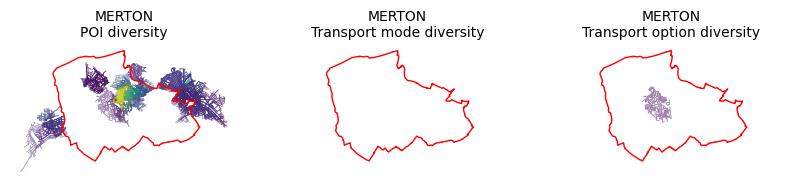

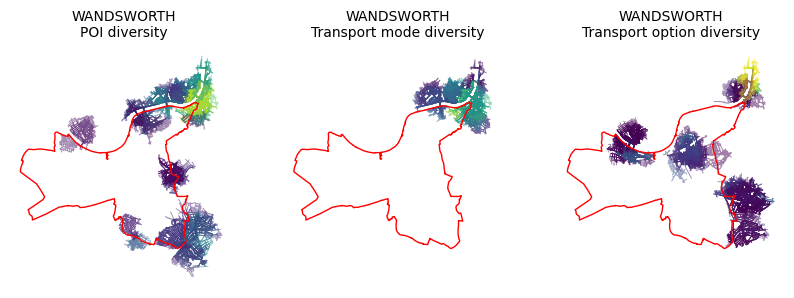

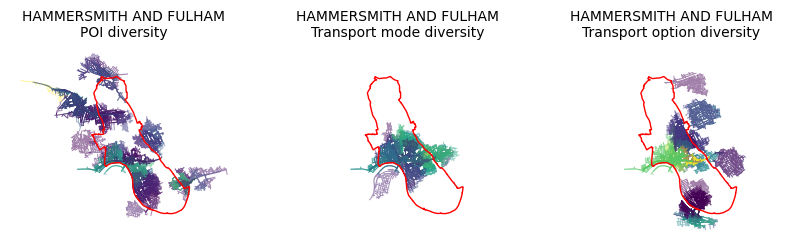

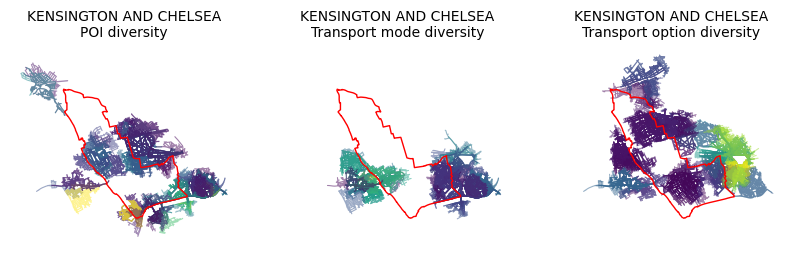

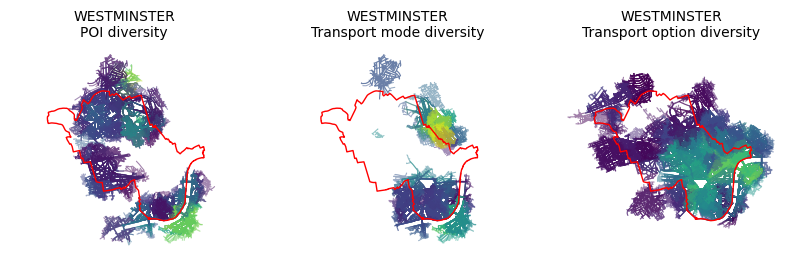

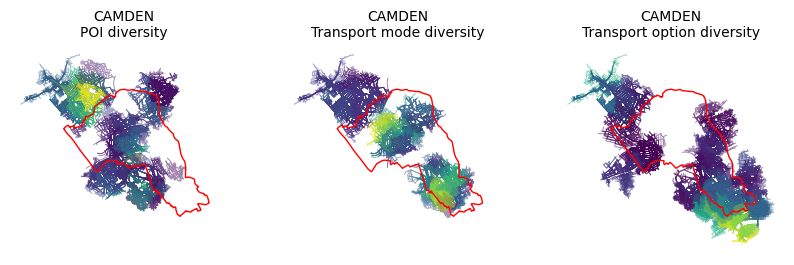

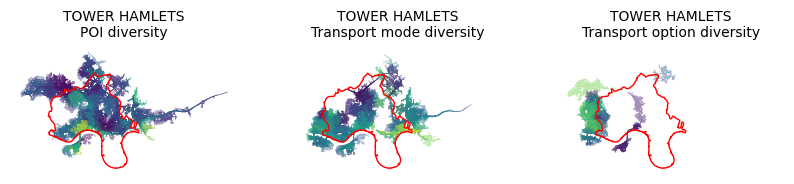

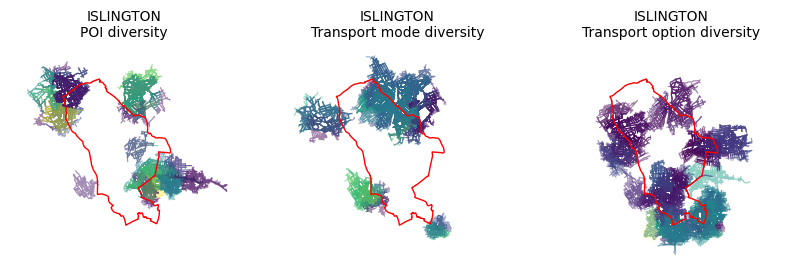

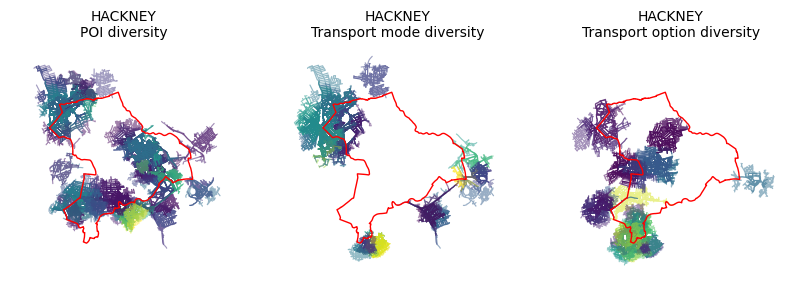

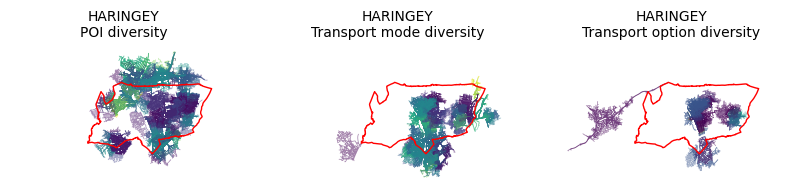

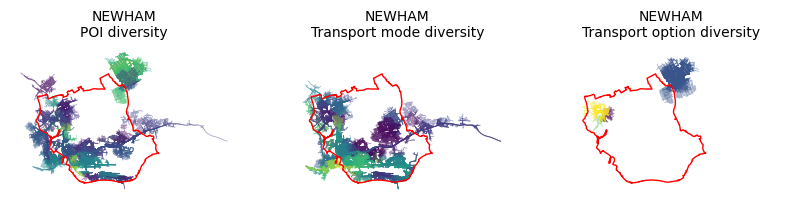

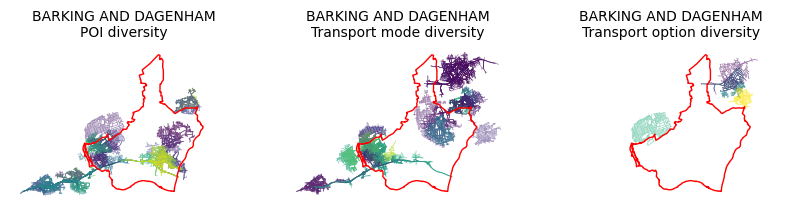

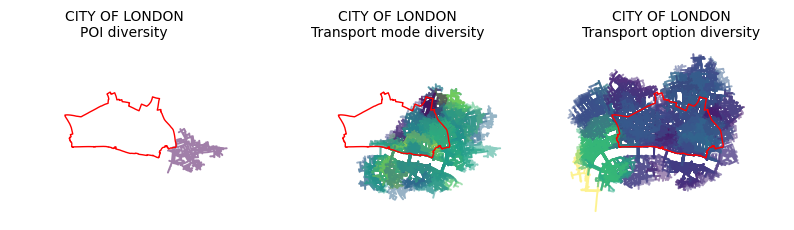

In [31]:
# for each boro in boro geodataframe, plot ALL THREE diversity maps
for boro in boros.iterrows():
    fig, ax = plt.subplots(1,3,sharex=True, sharey=True,figsize=(10,10))
    
    boro_name = boro[1].NAME
    boro_geom = boro[1].geometry
    boros[boros.NAME == boro_name].boundary.plot(ax=ax[0], color='red', linewidth=1)
    boros[boros.NAME == boro_name].boundary.plot(ax=ax[1], color='red', linewidth=1)
    boros[boros.NAME == boro_name].boundary.plot(ax=ax[2], color='red', linewidth=1)

    df_plot = df_ml_div[df_ml_div.diversity_poi > df_ml_div.diversity_poi.quantile(0.90)]
    df_plot[df_plot.intersects(boro_geom)].plot(
        column='diversity_poi',
        ax=ax[0],
        legend=False,
        alpha=0.5,
        cmap='viridis'
    )
    ax[0].axis('off')
    ax[0].set_aspect('equal', adjustable='box')
    ax[0].set_title(f'{boro_name.upper()}\nPOI diversity', fontsize=10)

    
    df_plot = df_ml_div[df_ml_div.diversity_transp_mode > df_ml_div.diversity_transp_mode.quantile(0.90)] 
    df_plot[df_plot.intersects(boro_geom)].plot(
        column='diversity_transp_mode',
        ax=ax[1],
        legend=False,
        alpha=0.5,
        cmap='viridis'
    )
    ax[1].axis('off')
    ax[1].set_aspect('equal', adjustable='box')
    ax[1].set_title(f'{boro_name.upper()}\nTransport mode diversity', fontsize=10)

    df_plot = df_ml_div[df_ml_div.diversity_transp_opt > df_ml_div.diversity_transp_opt.quantile(0.90)]
    df_plot[df_plot.intersects(boro_geom)].plot(
        column='diversity_transp_opt',
        ax=ax[2],
        legend=False,
        alpha=0.5,
        cmap='viridis'
    )
    ax[2].axis('off')
    ax[2].set_aspect('equal', adjustable='box')
    ax[2].set_title(f'{boro_name.upper()}\nTransport option diversity', fontsize=10)

    plt.savefig(os.path.join('output','div',f'div_{boro_name}.png'))
    plt.show()

In [33]:
# save to csv
df_ml_div.to_csv(os.path.join('data','cleaned','df_ml_34.csv'),index=False)

#### 3.5 Aggregate centrality measures (max_rail, max_bus, combined) for each isochrone

In [ ]:
df_ml_cent = df_ml_div.copy()

In [34]:
# df_ml_cent = df_ml.copy()

In [35]:
bus_cent = gpd.read_file(os.path.join('data','cleaned','bus_cent_h3_r10.gpkg'),driver='GPKG',crs='EPSG:27700')
rail_cent = gpd.read_file(os.path.join('data','cleaned','rail_cent_h3_r8.gpkg'),driver='GPKG',crs='EPSG:27700')

In [36]:
bus_cent.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 20060 entries, 0 to 20059
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   h3_10          20060 non-null  object  
 1   STOP_CODE      20060 non-null  object  
 2   STOP_NAME      20060 non-null  object  
 3   degree         20060 non-null  float64 
 4   betweenness_t  20060 non-null  float64 
 5   closeness_t    20060 non-null  float64 
 6   geometry       20060 non-null  geometry
dtypes: float64(3), geometry(1), object(3)
memory usage: 1.1+ MB


In [37]:
rail_cent.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 401 entries, 0 to 400
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   h3_08          401 non-null    object  
 1   station_name   401 non-null    object  
 2   degree         401 non-null    float64 
 3   betweenness_t  401 non-null    float64 
 4   closeness_t    401 non-null    float64 
 5   pagerank_t     401 non-null    float64 
 6   geometry       401 non-null    geometry
dtypes: float64(4), geometry(1), object(2)
memory usage: 22.1+ KB


In [38]:
# iterate through each row of df_ml_cent, find the corresponding intersecting hexagon in bus_cent, and copy the max value of each column
for i, row in df_ml_cent.iterrows():
    intersect = bus_cent[bus_cent.geometry.intersects(row.geometry)] # find intersected polygons
    #for all columns except geometry, rename to bus_
    for col in intersect[['degree','closeness_t','betweenness_t']].columns: 
        value = intersect[col].max()
        df_ml_cent.at[i, f'bus_{col}'] = value
    # print progress
    if i%100==0:
        print(f'{i} of {len(df_ml_cent)} done')

0 of 17342 done
100 of 17342 done
200 of 17342 done
300 of 17342 done
400 of 17342 done
500 of 17342 done
600 of 17342 done
700 of 17342 done
800 of 17342 done
900 of 17342 done
1000 of 17342 done
1100 of 17342 done
1200 of 17342 done
1300 of 17342 done
1400 of 17342 done
1500 of 17342 done
1600 of 17342 done
1700 of 17342 done
1800 of 17342 done
1900 of 17342 done
2000 of 17342 done
2100 of 17342 done
2200 of 17342 done
2300 of 17342 done
2400 of 17342 done
2500 of 17342 done
2600 of 17342 done
2700 of 17342 done
2800 of 17342 done
2900 of 17342 done
3000 of 17342 done
3100 of 17342 done
3200 of 17342 done
3300 of 17342 done
3400 of 17342 done
3500 of 17342 done
3600 of 17342 done
3700 of 17342 done
3800 of 17342 done
3900 of 17342 done
4000 of 17342 done
4100 of 17342 done
4200 of 17342 done
4300 of 17342 done
4400 of 17342 done
4500 of 17342 done
4600 of 17342 done
4700 of 17342 done
4800 of 17342 done
4900 of 17342 done
5000 of 17342 done
5100 of 17342 done
5200 of 17342 done
5300 

In [39]:
# iterate through each row of df_ml_cent, find the corresponding intersecting hexagon in bus_cent, and copy the max value of each column
for i, row in df_ml_cent.iterrows():
    intersect = rail_cent[rail_cent.geometry.intersects(row.geometry)] # find intersected polygons
    #for all columns except geometry, rename to bus_
    for col in intersect[['degree','closeness_t','betweenness_t']].columns:
        value = intersect[col].max()
        df_ml_cent.at[i, f'rail_{col}'] = value
    # print progress
    if i%100==0:
        print(f'{i} of {len(df_ml_cent)} done')

0 of 17342 done
100 of 17342 done
200 of 17342 done
300 of 17342 done
400 of 17342 done
500 of 17342 done
600 of 17342 done
700 of 17342 done
800 of 17342 done
900 of 17342 done
1000 of 17342 done
1100 of 17342 done
1200 of 17342 done
1300 of 17342 done
1400 of 17342 done
1500 of 17342 done
1600 of 17342 done
1700 of 17342 done
1800 of 17342 done
1900 of 17342 done
2000 of 17342 done
2100 of 17342 done
2200 of 17342 done
2300 of 17342 done
2400 of 17342 done
2500 of 17342 done
2600 of 17342 done
2700 of 17342 done
2800 of 17342 done
2900 of 17342 done
3000 of 17342 done
3100 of 17342 done
3200 of 17342 done
3300 of 17342 done
3400 of 17342 done
3500 of 17342 done
3600 of 17342 done
3700 of 17342 done
3800 of 17342 done
3900 of 17342 done
4000 of 17342 done
4100 of 17342 done
4200 of 17342 done
4300 of 17342 done
4400 of 17342 done
4500 of 17342 done
4600 of 17342 done
4700 of 17342 done
4800 of 17342 done
4900 of 17342 done
5000 of 17342 done
5100 of 17342 done
5200 of 17342 done
5300 

In [40]:
df_ml_cent.isnull().sum()

id_code                         0
pt_type                         0
geometry                        0
Early                           0
AM Peak                         0
Midday                          0
PM Peak                         0
Evening                         0
Late                            0
Total                           0
population                      0
poi_banking                     0
poi_hotels                      0
poi_leisure_active              0
poi_leisure_entertainment       0
poi_leisure_outdoor             0
poi_medical                     0
poi_nature                      0
poi_public_facilities           0
poi_religious                   0
poi_restaurants                 0
poi_shopping                    0
poi_tourism                     0
transport_bus                   0
transport_other                 0
transport_rail                  0
diversity_poi                   0
diversity_transport_mode        0
diversity_transp_opt            0
bus_degree    

In [41]:
#fill NaN with 0
df_ml_cent.fillna(0,inplace=True)

In [42]:
df_ml_cent.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 17342 entries, 0 to 17341
Data columns (total 35 columns):
 #   Column                     Non-Null Count  Dtype   
---  ------                     --------------  -----   
 0   id_code                    17342 non-null  object  
 1   pt_type                    17342 non-null  object  
 2   geometry                   17342 non-null  geometry
 3   Early                      17342 non-null  int32   
 4   AM Peak                    17342 non-null  int64   
 5   Midday                     17342 non-null  int64   
 6   PM Peak                    17342 non-null  int64   
 7   Evening                    17342 non-null  int64   
 8   Late                       17342 non-null  int64   
 9   Total                      17342 non-null  int32   
 10  population                 17342 non-null  float64 
 11  poi_banking                17342 non-null  float64 
 12  poi_hotels                 17342 non-null  float64 
 13  poi_leisure_active     

In [43]:
# save to csv
df_ml_cent.to_csv(os.path.join('data','cleaned','df_ml_35.csv'),index=False)

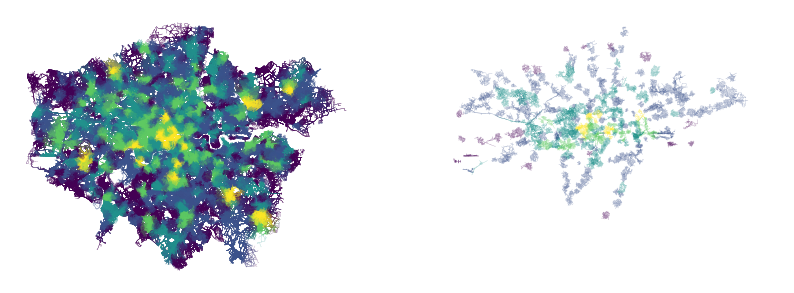

In [44]:
# plot degree
fig, ax = plt.subplots(1,2,figsize=(10,20),sharex=True,sharey=True)
df_ml_cent[df_ml_cent.pt_type=='bus'].plot(ax=ax[0], column='bus_degree', alpha=0.5, cmap='viridis',scheme='NaturalBreaks',k=5)
df_ml_cent[df_ml_cent.pt_type=='rail'].plot(ax=ax[1], column='rail_degree', alpha=0.5, cmap='viridis',scheme='NaturalBreaks',k=5)
ax[0].axis('off')
ax[1].axis('off')
plt.show()

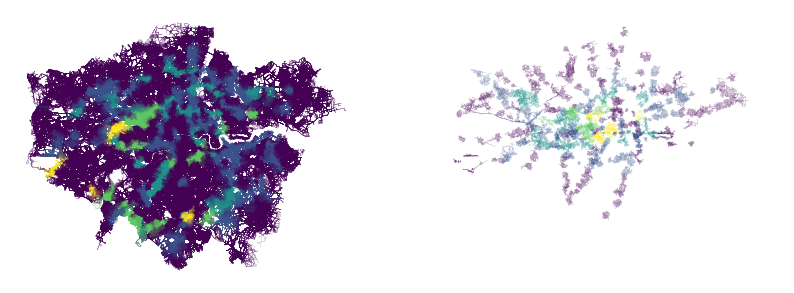

In [45]:
# plot betweenness_t
fig, ax = plt.subplots(1,2,figsize=(10,20),sharex=True,sharey=True)
df_ml_cent[df_ml_cent.pt_type=='bus'].plot(ax=ax[0], column='bus_betweenness_t', alpha=0.5, cmap='viridis',scheme='NaturalBreaks',k=5)
df_ml_cent[df_ml_cent.pt_type=='rail'].plot(ax=ax[1], column='rail_betweenness_t', alpha=0.5, cmap='viridis',scheme='NaturalBreaks',k=5)
ax[0].axis('off')
ax[1].axis('off')
plt.show()

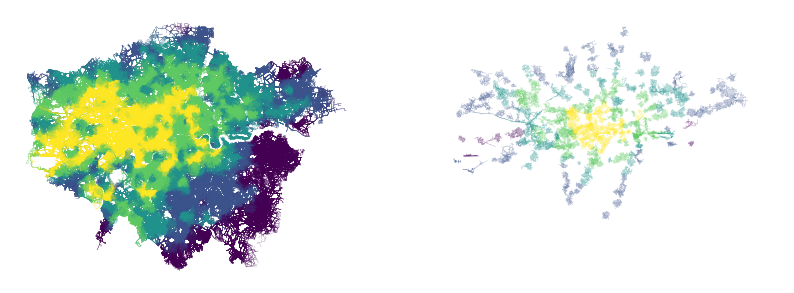

In [46]:
# plot closeness_t
fig, ax = plt.subplots(1,2,figsize=(10,20),sharex=True,sharey=True)
df_ml_cent[df_ml_cent.pt_type=='bus'].plot(ax=ax[0], column='bus_closeness_t', alpha=0.5, cmap='viridis',scheme='NaturalBreaks',k=5)
df_ml_cent[df_ml_cent.pt_type=='rail'].plot(ax=ax[1], column='rail_closeness_t', alpha=0.5, cmap='viridis',scheme='NaturalBreaks',k=5)
ax[0].axis('off')
ax[1].axis('off')
plt.show()

Save as CSV

In [47]:
# # drop geometry column
# final_df_nogeo = df_ml_cent.drop('geometry',axis=1)
# final_df_nogeo.to_csv(os.path.join('data','cleaned','df_ml_35_nogeo.csv'),index=False)

Appendix

In [67]:
# # transform geomtry column to geodataframe
# dff['geometry'] = gpd.GeoSeries.from_wkt(dff['geometry'])
# dff = gpd.GeoDataFrame(dff, crs='EPSG:27700')

# # delete columns 3-9
# dff.drop(dff.columns[3:10],axis=1,inplace=True)
# dff.drop(columns=['pt_type'],inplace=True)
# dff.info()

In [68]:
# dff['total_exits'] = dff['total_rail_exits'] + dff['total_bus_exits']
# # rename columns
# dff.rename(columns={'total_rail_exits':'Total_rail',
#                      'total_bus_exits':'Total_bus',
#                      'total_exits':'Total_railbus'},inplace=True)

In [69]:
# timebands_ = ['Early', 'AM Peak', 'Midday', 'PM Peak', 'Evening', 'Late']

In [70]:
# # sum columns 2-8 of flow_rail that intersects with each isochrone
# for i, row in dff.iterrows():
#     intersect = flow_rail[flow_rail.geometry.intersects(row.geometry)] # find intersected polygons
#     for col in flow_rail[timebands_].columns:
#         value = intersect[col].sum()
#         dff.at[i, col] = round(value)
#     # print progress
#     if i%100==0:
#         print(f'{i} of {len(dff)} done')

# # rename new columns adding a suffix _rail
# for col in timebands_:
#     dff.rename(columns={col: col+'_rail'}, inplace=True)

In [28]:
# dff.to_csv(os.path.join('data','cleaned','df_ml_tb_rail.csv'),index=False)
# # drop geometry column
# dffe = dff.drop('geometry',axis=1)
# dffe.to_csv(os.path.join('data','cleaned','df_ml_tb_rail_nogeo.csv'),index=False)

In [43]:
# # spatial weight matrix distance based
# from libpysal.weights import DistanceBand

In [ ]:
# for thres in range(100,1600,100):
#     w = DistanceBand.from_dataframe(dff,threshold=thres)
#     # record number of neighbours in a dataframe
#     dff[f'neighbours_{thres}'] = [w.cardinalities[i] for i in range(len(dff))]

In [ ]:
# w = DistanceBand.from_dataframe(dff,threshold=1000)
# w.transform = 'r'

# # how to add the spatial weight matrix to the dataframe
# dff['w'] = w.sparse
# dff['w'] = dff['w'].apply(lambda x: x.toarray().flatten())
